<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [TRANS2] - IMDB, Sentiment analysis with Transformers
<!-- DESC --> Using a Tranformer to perform a sentiment analysis (IMDB) - Colab version
<!-- AUTHOR : Hatim Bourfoune (IDRIS) and Nathan Cassereau (IDRIS) -->

By : Hatim Bourfoune (IDRIS) and Nathan Cassereau (IDRIS)


## Objectives :
 - Complement the learning of a Transformer to perform a sentiment analysis
 - Understand the use of a pre-trained transformer

This task is exactly the same as the Sentiment analysis with text embedding. Only this time,
we are going to exploit the strenght of transformers. Considering how computation-heavy transformer
pretraining is, we are going to use a pretrained BERT model from HuggingFace.
This notebook performs the fine-tuning process. If possible, try to use a GPU to speed up
the training, transformers are difficult to train on CPU.

## What we are going to do:

* Retrieve the dataset
* Prepare the dataset
* Fetch a pretrained BERT model from HuggingFace's platform (https://huggingface.co/models)
* Fine-tune the model on a sequence classification task: the sentiment analysis of the IMDB dataset
* Evaluate the result


## Installations

**IMPORTANT :** We will need to use the library `transformers` created by HuggingFace.

In [ ]:
!pip install transformers

## Imports and initialisation

In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

from transformers import (
    DistilBertTokenizer,
    TFDistilBertModel,
    DataCollatorWithPadding,
    BertTokenizer,
    TFBertModel
)

from tqdm.notebook import tqdm
import itertools
import multiprocessing
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Tensorflow ", tf.__version__)
n_gpus = len(tf.config.list_physical_devices('GPU'))
print("#GPUs: ", n_gpus)
if n_gpus > 0:
    !nvidia-smi -L
os.environ["TOKENIZERS_PARALLELISM"] = "true"

np.random.seed(987654321)
tf.random.set_seed(987654321)

Tensorflow  2.15.0
#GPUs:  1
GPU 0: Tesla T4 (UUID: GPU-c82a1be1-6dfd-7836-5585-ec8be581b6aa)


## Parameters

* `vocab_size` refers to the number of words which will be remembered in our vocabulary.
* `hide_most_frequently` is the number of ignored words, among the most common ones.
* `review_len` is the review length.
* `n_cpus` is the number of CPU which will be used for data preprocessing.
* `distil` refers to whether or not we are going to use a DistilBert model or a regular Bert model.

In [ ]:
vocab_size = 30000
hide_most_frequently = 0

review_len = 512

epochs = 1
batch_size = 32

fit_verbosity = 1
scale = 1

n_cpus = 1
distil = True

## Retrieve the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=vocab_size,
    skip_top=hide_most_frequently,
    seed=123456789,
)


y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

n1 = int(scale * len(x_train))
n2 = int(scale * len(x_test))
x_train, y_train = x_train[:n1], y_train[:n1]
x_test,  y_test  = x_test[:n2],  y_test[:n2]

print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))
print('\nReview sample (x_train[12]) :\n\n',x_train[12])

x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)

Review sample (x_train[12]) :

 [1, 13, 124, 4, 84, 5, 13, 122, 49, 7, 4, 748, 5, 2177, 1592, 5, 4, 123, 9, 527, 36, 26, 1026, 117, 362, 37, 92, 28, 101, 676, 5, 242, 43, 11595, 1851, 8, 1779, 98, 2365, 47, 256, 4, 9397, 18, 31, 2, 207, 256, 18, 470, 300, 241, 4, 20, 9, 394, 5, 38, 9, 4, 123, 14, 9, 4, 24370, 91, 1849, 56, 212, 15, 60, 2, 163, 207, 126, 110, 12, 9, 38, 379, 12, 166, 72, 181, 8, 19361, 12, 9, 43, 38, 932, 15, 14002, 62, 126, 1779, 142, 40, 14, 5, 38, 995, 36, 26, 12373, 379, 5, 916, 13, 784, 98, 5, 68, 123, 5, 104, 280, 1851, 2503, 89, 379, 12, 9, 36, 80, 91, 2363, 193, 12, 125]


In [ ]:
word_index = imdb.get_word_index()

word_index = {w:(i+3) for w,i in word_index.items()}
word_index.update({'[PAD]':0, '[CLS]':1, '[UNK]':2})
index_word = {index:word for word,index in word_index.items()}

# Add a nice function to transpose:
def dataset2text(review):
    return ' '.join([index_word.get(i, "?") for i in review[1:]])

1641221/1641221 [==============================] - 1s 1us/step


In [ ]:
print(dataset2text(x_train[12]))

i know the people and i did some of the animation and graphic design and the show is horrible they are rich little kids who don't have any talent and probably just begged nick to accept them alex has played the drums for one [UNK] i've played for 4 1 2 the movie is terrible and so is the show this is the craziest most mixed up comedy that even [UNK] funny i've ever seen it is so stupid it makes me want to barf it is just so crazy that nickelodeon would ever accept something like this and so dumb they are sooo stupid and weird i hate them and their show and think once nick realizes how stupid it is they will most hopefully take it off


## Fetch the model from HuggingFace

In [ ]:
def load_model(distil):
    if distil:
        bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    else:
        bert_model = TFBertModel.from_pretrained("bert-base-uncased")
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    return bert_model, tokenizer

bert_model, tokenizer = load_model(distil)
bert_model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Prepare the dataset

In [ ]:
def tokenize_sample(sample):
    return tokenizer(dataset2text(sample), truncation=True, max_length=review_len)

def distributed_tokenize_dataset(dataset):
    ds = list(dataset)
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        tokenized_ds = list(tqdm(
            pool.imap(tokenize_sample, ds),
            total=len(ds)
        ))
    return tokenized_ds

tokenized_x_train = distributed_tokenize_dataset(x_train)
tokenized_x_test = distributed_tokenize_dataset(x_test)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

In [ ]:
data_collator(tokenized_x_train)

{'input_ids': <tf.Tensor: shape=(25000, 512), dtype=int32, numpy=
array([[ 101, 1045, 3294, ...,    0,    0,    0],
       [ 101, 2070, 3152, ...,    0,    0,    0],
       [ 101, 2013, 1996, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2031, ...,    0,    0,    0],
       [ 101, 2034, 2051, ...,    0,    0,    0],
       [ 101, 8040, 9541, ..., 3382, 2003,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25000, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
def make_dataset(x, y):
    collated = data_collator(x)
    dataset = tf.data.Dataset.from_tensor_slices(
        (collated['input_ids'], collated['attention_mask'], y)
    )
    transformed_dataset = (
        dataset
        .map(
            lambda x, y, z: ((x, y), z)
        )
        .shuffle(25000)
        .batch(batch_size)
    )
    return transformed_dataset

train_ds = make_dataset(tokenized_x_train, y_train)
test_ds = make_dataset(tokenized_x_test, y_test)

for x, y in train_ds:
    print(x)
    break

(<tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[  101,  1996,  6358, ...,     0,     0,     0],
       [  101,  2009,  2318, ...,     0,     0,     0],
       [  101,  2023,  2143, ...,     0,     0,     0],
       ...,
       [  101, 10356, 14174, ...,  1005,  1056,   102],
       [  101, 11519,  2438, ...,     0,     0,     0],
       [  101,  2023,  2003, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(32, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)


## Add a new head to the model

In [ ]:
class ClassificationModel(keras.Model):

    def __init__(self, bert_model):
        super(ClassificationModel, self).__init__()
        self.bert_model = bert_model
        self.pre_classifier = Dense(768, activation='relu')
        self.dropout = Dropout(0.1)
        self.classifier = Dense(2)

    def call(self, x):
        x = self.bert_model(x)
        x = x.last_hidden_state
        x = x[:, 0] # get the output of the classification token
        x = self.pre_classifier(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [ ]:
model = ClassificationModel(bert_model)
x = next(iter(train_ds))[0]
model(x)
model.summary()

Model: "classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  590592    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  1538      
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Train!

In [ ]:
model.compile(
    optimizer=Adam(1e-05),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy('accuracy')]
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    verbose=fit_verbosity
)

782/782 [==============================] - 1319s 2s/step - loss: 0.2615 - accuracy: 0.8911


## Evaluation

782/782 [==============================] - 487s 616ms/step - loss: 0.1930 - accuracy: 0.9237


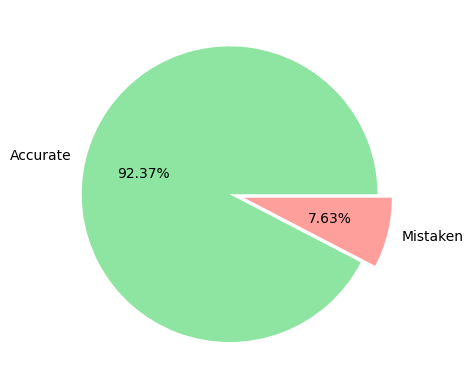

In [ ]:
_, score = model.evaluate(test_ds)
colors = sns.color_palette('pastel')[2:]
accuracy_score = [score, 1 - score]
plt.pie(
    accuracy_score,
    labels=["Accurate", "Mistaken"],
    colors=colors,
    autopct=lambda val: f"{val:.2f}%",
    explode=(0.0, 0.1)
)
plt.show()